# Image Classification using Satellite Images and CNNs: Preprocessing, Analysis and Evaluation
### By: Christian Tan_PH

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;This notebook provides an in-depth solution for training a machine learning model for image classification using satellite image chips with various land cover/land use and atmospheric conditions. <br> <br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;It covers all essential stages such as data preparation, data analysis, model definition, training, evaluation and prediction. The code employs various libraries like numpy, pandas, matplotlib, tensorflow, keras, and scikit-learn to perform different tasks. The CNN architecture is used to train the model, which is a robust model for image classification tasks.<br><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;This code is perfect as a starting point for building similar models for image classification tasks and can be easily adapted to different datasets and requirements.

# Importing Libraries

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

import os
import gc

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential 

import keras as k
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization

import cv2
from tqdm import tqdm
from collections import Counter

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score

import plotly.express as px


# Loading The Dataset

In [2]:
# Define the base path for the dataset
path = "../input/planets-dataset/planet/planet/"

# Join the base path with the train-jpg folder
path_train = os.path.join(path, "train-jpg")

# Join the base path with the test-jpg folder
path_test = os.path.join(path, "test-jpg")

# Use the os.listdir function to get the number of files in the train-jpg and test-jpg folders
print(
    f"train files: {len(os.listdir(path_train))}, "
    f"test files: {len(os.listdir(path_test))}"
)


train files: 40479, test files: 40669


In [3]:
# Define the path to the train_classes.csv file
path_train_class = os.path.join(path, "train_classes.csv")

# Read the train_classes.csv file and store it in a DataFrame
df_train = pd.read_csv(path_train_class)

# Print the shape of the DataFrame
print(df_train.shape)

# Display the first 5 rows of the DataFrame
df_train.head()

(40479, 2)


,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


# Exploring and Understanding the Labels in the dataset

In [4]:
# Number Of Unique Tags In The Dataset
# Avereage # Of Labels Per Image

all_tags = [item for sublist in list(df_train['tags'].apply(lambda row: row.split(" ")).values) for item in sublist]
print('total of {} non-unique tags in all training images'.format(len(all_tags)))
print('average number of labels per image {}'.format(1.0*len(all_tags)/df_train.shape[0]))

total of 116278 non-unique tags in all training images
average number of labels per image 2.8725511993873365


In [5]:
# Label Distribution

# Add a new column 'list_tags' to the DataFrame by splitting the 'tags' column on the space character
df_train["list_tags"] = df_train.tags.str.split(" ")

# Get the values of the new column
row_tags = df_train.list_tags.values

# Flatten the list of tags
tags = [tag for row in row_tags for tag in row]

# Count the occurrences of each tag
counter_tags = Counter(tags)

# Create a new DataFrame with the tag and total columns
df_tags = pd.DataFrame(
    {"tag": counter_tags.keys(), "total": counter_tags.values()}
).sort_values("total")

# Create a bar chart of the tag distribution using Plotly
fig = px.bar(df_tags, x="total", y="tag", orientation="h", 
             color="total",
)

# Update the chart title
fig.update_layout(title="Tags distribution")

# Show the chart
fig.show()


# Machine Learning
## Preparing the Data

In [6]:
# Drop the created "list_tags" column

df_train = df_train.drop("list_tags", axis='columns')
df_train.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [7]:
# Initialization and Image Reading

# Initialize empty lists to store the training images and their labels
x_train = []
y_train = []

# Flatten the list of tags
flatten = lambda l: [item for sublist in l for item in sublist]
labels = list(set(flatten([l.split(' ') for l in df_train['tags'].values])))

# Create a label map for the unique tags in the dataset
label_map = {l: i for i, l in enumerate(labels)}
inv_label_map = {i: l for l, i in label_map.items()}

# Loop through the training DataFrame
for f, tags in tqdm(df_train.values, miniters=1000):
    # Read the image file
    img = cv2.imread('../input/planets-dataset/planet/planet/train-jpg/{}.jpg'.format(f))
    # Initialize an array of zeros for the targets
    targets = np.zeros(17)
    # Loop through the tags for the current image
    for t in tags.split(' '):
        # Set the corresponding target value to 1
        targets[label_map[t]] = 1 
    # Append the image and its labels to the appropriate lists
    x_train.append(cv2.resize(img, (64, 64)))  # Indicate the IMG Size
    y_train.append(targets)

# Convert the lists to numpy arrays
x_train = np.array(x_train, np.float16) / 255.
y_train = np.array(y_train, np.uint8)


100%|██████████| 40479/40479 [06:56<00:00, 97.16it/s] 


In [8]:
# Converting the lists of images and labels to numpy arrays and normalizing the pixel values of the images. 
y_train = np.array(y_train, np.uint8)
x_train = np.array(x_train, np.float16) / 255.0

# Splitting the data into train and validation sets. 
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2, shuffle = True, random_state = 1)

# Prints the shape of the training and validation data.
print("Train data shape:",x_train.shape)
print("Train label shape:",y_train.shape)

print("Validation data shape:",x_val.shape)
print("Validation label shape:",y_val.shape)


Train data shape: (32383, 64, 64, 3)
Train label shape: (32383, 17)
Validation data shape: (8096, 64, 64, 3)
Validation label shape: (8096, 17)


In [9]:
# Free up some memory that is not being used by the program
gc.collect()


100

## Establishing Evaluation Metrics for the Model

In [10]:
# Defining a function that calculates the F-beta score for a given set of true labels and predicted labels.
# The function balances precision and recall and it is useful when there is an imbalance in the number of positive and negative examples in the data.

def fbeta(y_true, y_pred, threshold_shift=0):
    beta = 2

    # Clipping y_pred between 0 and 1
    y_pred = K.clip(y_pred, 0, 1)

    # Rounding y_pred to binary values
    y_pred_bin = K.round(y_pred + threshold_shift)

    # Counting true positives, false positives, and false negatives
    tp = K.sum(K.round(y_true * y_pred_bin)) + K.epsilon()
    fp = K.sum(K.round(K.clip(y_pred_bin - y_true, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)))

    # Calculating precision and recall
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    beta_squared = beta ** 2
    return (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon())


In [11]:
# This code defines a function that calculates the accuracy score for a given set of true labels and predicted labels.
def accuracy_score(y_true, y_pred, epsilon = 1e-4):
    
    # casting the true labels and predicted labels to float32
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(tf.greater(tf.cast(y_pred, tf.float32), tf.constant(0.5)), tf.float32)
    
    # counting the true positives
    tp = tf.reduce_sum(y_true * y_pred, axis = 1)
    
    # counting the false positives
    fp = tf.reduce_sum(y_pred, axis = 1) - tp
    
    # counting the false negatives
    fn = tf.reduce_sum(y_true, axis = 1) - tp
    
    # casting the true labels and predicted labels to boolean
    y_true = tf.cast(y_true, tf.bool)
    y_pred = tf.cast(y_pred, tf.bool)
    
    # counting the true negatives
    tn = tf.reduce_sum(tf.cast(tf.logical_not(y_true), tf.float32) * tf.cast(tf.logical_not(y_pred), tf.float32), 
                       axis = 1)
    #calculating the accuracy score
    return (tp + tn)/(tp + tn + fp + fn + epsilon)


## Constructing the Neural Network Architecture

In [12]:
# Importing different optimization algorithms from tensorflow.keras.optimizers
from tensorflow.keras.optimizers import Adam, Adagrad, RMSprop

# Instantiate the optimizer objects
optimizer_Adam = Adam()
optimizer_Adagrad = Adagrad()
optimizer_RMSprop = RMSprop()

In [13]:
# Define The Model
model = keras.Sequential()

# Adding The Layers
# Batch Normalization layer is added as the first layer of the model, which normalize the input data.
model.add(BatchNormalization(input_shape=(64, 64, 3)))

# Convolutional layers and MaxPooling layers are added to extract features from the input images and reduce the spatial dimensions of the feature maps respectively.
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Dropout layers are added to prevent overfitting.
model.add(Dropout(0.2))

# Same set of layers are added for the next set of features
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Flatten layer is added to convert the 2D feature maps into a 1D feature vector
model.add(Flatten())

# Fully connected layers (dense layers) and dropout layers are added
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(17, activation='sigmoid'))

# Compiling the model by specifying the loss function, optimizer, and evaluation metrics
model.compile(optimizer=optimizer_Adam,
              loss='binary_crossentropy',
              metrics=[fbeta, accuracy_score])

# Training the model on the training data for 10 epoch with a batch size of 128, and validating the model on the validation data
history = model.fit(x_train, y_train,
                      batch_size=128,
                      epochs=10,
                      verbose=1,
                      validation_data=(x_val, y_val))

2023-01-13 15:29:59.398335: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2023-01-13 15:30:02.771273: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
253/253 [==============================] - 232s 909ms/step - loss: 0.2378 - fbeta: 0.6217 - accuracy_score: 0.9088 - val_loss: 0.2442 - val_fbeta: 0.6256 - val_accuracy_score: 0.9086
Epoch 2/10
253/253 [==============================] - 228s 900ms/step - loss: 0.1991 - fbeta: 0.6860 - accuracy_score: 0.9224 - val_loss: 0.2255 - val_fbeta: 0.6748 - val_accuracy_score: 0.9180
Epoch 3/10
253/253 [==============================] - 231s 914ms/step - loss: 0.1790 - fbeta: 0.7221 - accuracy_score: 0.9292 - val_loss: 0.1643 - val_fbeta: 0.7578 - val_accuracy_score: 0.9344
Epoch 4/10
253/253 [==============================] - 228s 900ms/step - loss: 0.1642 - fbeta: 0.7485 - accuracy_score: 0.9350 - val_loss: 0.1551 - val_fbeta: 0.7703 - val_accuracy_score: 0.9391
Epoch 5/10
253/253 [==============================] - 227s 898ms/step - loss: 0.1559 - fbeta: 0.7639 - accuracy_score: 0.9387 - val_loss: 0.1454 - val_fbeta: 0.7771 - val_accuracy_score: 0.9432
Epoch 6/10
253/253 [==========

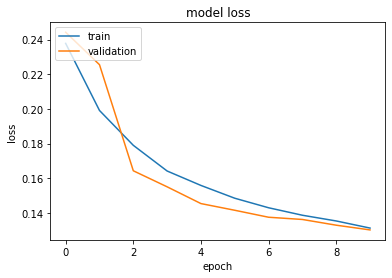

In [14]:
# Plotting the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

# Adding title, y-label and x-label to the plot
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

# Adding legend to the plot
plt.legend(['train', 'validation'], loc='upper left')

# Showing the plot
plt.show()


In [15]:
# Evaluate the model on the validation set
model.evaluate(x_val, y_val)

# Calculate the f-beta score for the training set
train_fscore = fbeta_score(y_train, np.round(model.predict(x_train)), beta=2,average = 'weighted')
print("train fscore: ", train_fscore)

# Calculate the f-beta score for the validation set
val_fscore = fbeta_score(y_val, np.round(model.predict(x_val)), beta=2, average = 'weighted')
print("val fscore: ", val_fscore)

253/253 [==============================] - 15s 59ms/step - loss: 0.1302 - fbeta: 0.8095 - accuracy_score: 0.9481
train fscore:  0.8106242876673606
val fscore:  0.7948617579447105


## Evaluating The Model Using The Test Data

In [16]:
# Read the sample submission CSV file and store it in a DataFrame
df_samplesub = pd.read_csv('../input/planets-dataset/planet/planet/sample_submission.csv')

# The DataFrame 'df_samplesub' now contains the data from the sample submission CSV file


In [17]:
# Create two separate DataFrames for the test and additional test files

# The first DataFrame will contain the labels for the test-jpg files
test = df_samplesub[0 : 40669]

# The second DataFrame will contain the labels for the test-jpg-additional files
files = df_samplesub[40669 : ]


In [18]:
# Loading the test images

# Initialize an empty list to store the images
test_img = []

# Loop through the test DataFrame
for image_name, tags in tqdm(test.values, miniters=1000):
    # Read the image file
    arr = cv2.imread('../input/planets-dataset/planet/planet/test-jpg/{}.jpg'.format(image_name))
    # Resize the image to (64, 64)
    test_img.append(cv2.resize(arr, (64, 64)))

# Loop through the additional test files DataFrame
for image_name, tags in tqdm(files.values, miniters=1000):
    # Read the image file
    arr = cv2.imread('../input/planets-dataset/test-jpg-additional/test-jpg-additional/{}.jpg'.format(image_name))
    # Resize the image to (64, 64)
    test_img.append(cv2.resize(arr, (64, 64)))

# Convert the list of images to a numpy array and normalize the pixel values
test_img = np.array(test_img, np.float16)/255.0


100%|██████████| 20522/20522 [04:11<00:00, 81.73it/s]


In [19]:
# Free up some memory that is not being used by the program.. again
gc.collect()


6557

In [20]:
# Running the predictions

# Initialize an empty list to store the predictions
yres = []

# Make predictions on the test images using the model
predictions = model.predict(test_img, batch_size = 64, verbose = 2)

# Append the predictions to the yres list
yres.append(predictions)


957/957 - 103s


In [21]:
# Free up some memory that is not being used by the program.. again again
gc.collect()


790

In [22]:
# Convert the encoded labels back to their original form

# Initialize an empty array to store the decoded labels
sub = np.array(yres[0])

# Loop through the encoded labels
for i in range (1, len(yres)):
    # Add the encoded label to the array
    sub += np.array(yres[i])

# Convert the array to a DataFrame
sub = pd.DataFrame(sub, columns = label_map)


In [23]:
# Create the submission file format

# Initialize an empty list to store the predictions
preds = []

# Loop through the sample submission DataFrame
for i in tqdm(range(sub.shape[0]), miniters=1000):
    # Get the i-th row of the DataFrame
    a = sub.loc[[i]]
    # Apply a lambda function to get a Boolean array indicating which columns have values greater than 0.2
    a = a.apply(lambda x: x > 0.2, axis=1)
    # Transpose the DataFrame
    a = a.transpose()
    # Get the rows where the Boolean array is True
    a= a.loc[a[i] == True]
    # Join the index of the DataFrame (which contains the tags) into a single string
    ' '.join(list(a.index))
    # Append the string of tags to the preds list
    preds.append(' '.join(list(a.index)))

# Assign the preds list as the 'tags' column of the sample submission DataFrame
df_samplesub['tags'] = preds

# Save the sample submission DataFrame to a CSV file
df_samplesub.to_csv('CMT_submission.csv', index=False)


100%|██████████| 61191/61191 [01:52<00:00, 543.20it/s]
